In [17]:
import os
import torch
from PIL import Image
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model and feature extractor
extractor = AutoFeatureExtractor.from_pretrained("rafalosa/diabetic-retinopathy-224-procnorm-vit")
model = AutoModelForImageClassification.from_pretrained("rafalosa/diabetic-retinopathy-224-procnorm-vit")

c:\Users\bryon\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [23]:
# Evaluation data folder path and mapping of folder names to labels
evaluation_data_folder = "images/evaluation/"
label_mapping = {
    "No_DR": 0,
    "Mild": 1,
    "Moderate": 2,
    "Severe": 3,
    "Proliferate_DR": 4
}

# Reverse the label_mapping to get the original names from numbers
reverse_label_mapping = {v: k for k, v in label_mapping.items()}


In [26]:
# Function to generate true and predicted labels for a given folder
def generate_labels_for_folder(data_folder, label_mapping):
    true_labels = []
    predicted_labels = []

    for image_filename in os.listdir(data_folder):
        image_path = os.path.join(data_folder, image_filename)
        image = Image.open(image_path)
        inputs = extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=1)
        predicted_class_idx = torch.argmax(probs, dim=1).item()
        predicted_label = reverse_label_mapping.get(predicted_class_idx, "Unknown Label")

        folder_name = os.path.basename(data_folder)
        label = reverse_label_mapping.get(label_mapping.get(folder_name, -1), "Unknown Label")

        true_labels.append(label)
        predicted_labels.append(predicted_label)
        # print(f"Predicted Label: {predicted_label}, True Label: {label}")
    return true_labels, predicted_labels


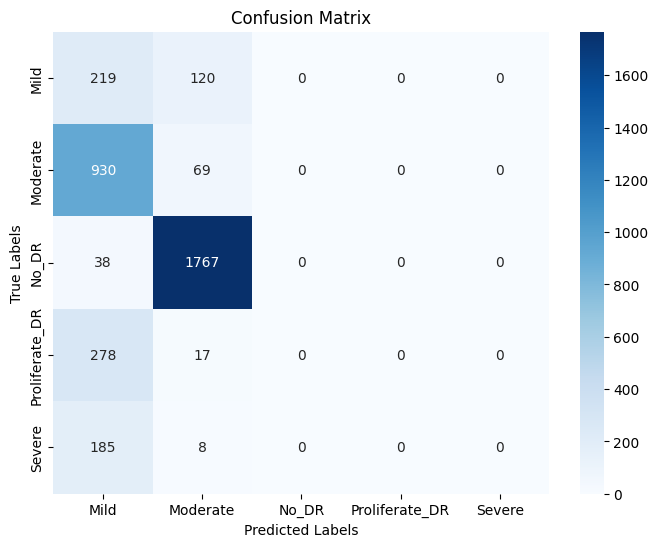

In [27]:

# Call the function for each folder to generate true and predicted labels
folder_true_labels = []
folder_predicted_labels = []
for folder_name in os.listdir(evaluation_data_folder):
    folder_path = os.path.join(evaluation_data_folder, folder_name)
    true_labels, predicted_labels = generate_labels_for_folder(folder_path, label_mapping)
    folder_true_labels.extend(true_labels)
    folder_predicted_labels.extend(predicted_labels)

# Compute the confusion matrix for all folders
conf_matrix = confusion_matrix(folder_true_labels, folder_predicted_labels)

# Get the class names in the correct order for the confusion matrix
class_names = [label for label in label_mapping.keys()]
class_names.sort()

# Create a heatmap visualization using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()